In [86]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as opt

import models_fit
import astro_models

import emcee
% matplotlib inline

import inspect

import warnings 
warnings.filterwarnings("ignore")

In [70]:
def func(x, a, b, c):
    return a+b*x+c*x**2

In [36]:
c1 = 10
c2 = 3
c3 = 10

xdata = np.linspace(0,1, 100)

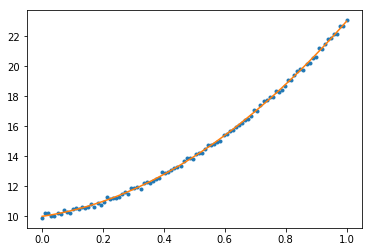

In [37]:
noise = np.random.normal(0, 1e-1, len(xdata))
ydata = func(xdata, c1, c2, c3)


plt.plot(xdata, ydata+noise,'.')
plt.plot(xdata, ydata)

In [107]:
b = 3
popt, pcov = opt.curve_fit(lambda x, a,c:func(x,a,b,c,), xdata, ydata+noise)
print(popt)

[ 9.99571164 10.02037546]


In [122]:
lparams = np.array(inspect.getargspec(func).args)

dparams = np.array(['b'])
fixedval= np.array([])
nparams = [sa for sa in lparams if not any(sb in sa for sb in dparams)]

In [127]:
mystr = 'new  = lambda '
for i in range(len(nparams)):
    mystr = mystr + nparams[i] +', '
mystr = mystr[:-2]
mystr = mystr +': func('
for i in range(len(lparams)):
    mystr = mystr + lparams[i] +', '
mystr = mystr[:-2]
mystr = mystr+')'
exec(mystr)

lambda x, a, c: func(x, a, b, c)


In [61]:
def address(variable):
    return hex(id(variable))
    
a=1
b=3
c=1
arr = address(obj.a),address(obj.b),address(obj.c)
sub = arr[0], arr[2]
popt, pcov = opt.curve_fit(lambda x, sub:func(x,arr), xdata, ydata+noise)
print(popt)

TypeError: func() missing 2 required positional arguments: 'b' and 'c'

In [80]:
mystr = 'print("hello world")'
exec(mystr)

hello world


In [82]:
inspect.getargspec(func)
inspect.getargspec(astro_models.ideal_lightcurve)

/Users/ldang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  """Entry point for launching an IPython kernel.


ArgSpec(args=['x', 'a', 'b', 'c'], varargs=None, keywords=None, defaults=None)

In [56]:
sub

('0x104e9e810', '0x104e9e830')

In [60]:
arr

('0x104e9e810', '0x104e9e830', '0x104e9e830')

In [25]:
class dummy(object):
    def __init__(self,a=0,b=1,c=1):
        self.a=a
        self.b=b
        self.c=c

In [26]:
obj = dummy()

In [31]:
arr = [obj.a,obj.b,obj.c]
lab = ['a','b','c']
ans = 'b'
arr.remove(np.where(lab==ans))

ValueError: list.remove(x): x not in list

In [34]:
arr = [a,c]

In [ ]:
b=10
lambda x, arr:func(x,a,b,c)

In [4]:
astro_models.ideal_lightcurve()

TypeError: ideal_lightcurve() missing 17 required positional arguments: 'time', 't0', 'per', 'rp', 'a', 'inc', 'ecosw', 'esinw', 'q1', 'q2', 'fp', 'A', 'B', 'C', 'D', 'r2', and 'mode'

In [61]:
popt

array([9.99093081, 9.99538051])

In [69]:
# Some variable def
r_star            = 1.377              # for XO-3 in solar radius
r_sol2jup         = 0.10049            # jupiter radius in solar radius
r_sol2AU          = 214.93946938       # AU radius in solar radius
hrs2days          = 1/24.0             # hour in days

t0   = 1.97                      # BMJD time
per  = 3.1915239                       # in days
rp   = 0.125/r_star                    # radius (in solar radius)/stellar radius (solar radius) 
a    = 0.0454*r_sol2AU/r_star          # 
inc  = 84.20                           # 90 = edge-on                
ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
q1   = 0.001
q2   = 0.001
fp   = 0.0015                           # eclipse depth in units of stellar flux

# Phase Variation Parameters (2 params)
A    = 0.1
B    = 0.0

# pre-calculation
mid_x = 15.1
mid_y = 15.2

# photometric scatter
sigmaf = 0.01

In [14]:
class orb_params(object):
    name  = 'planet'
    t0    = 1.97                            # BMJD time
    per   = 3.1915239                       # in days
    rp    = 0.08                             # planet radius in stellar radii  
    a     = 7                               # semi-major axis in stellar radii
    inc   = 84.20                           # in degrees 90 = edge-on                
    ecosw = 0.1                          
    esinw = 0.1                             
    q1    = 0.001
    q2    = 0.001
    fp    = 0.001                           # eclipse depth in units of stellar flux
    A     = 0.1
    B     = 0.0
    C     = 0.0
    D     = 0.0
    r2    = 0.08
    mode  = ''
    # class constructor
    def __init__(self, name, t0, per, rp, a, inc, ecosw, esinw, 
                 q1, q2, fp, A, B, C, D, r2, mode):
        self.name  = name  
        self.t0    = t0    
        self.per   = per   
        self.rp    = rp    
        self.a     = a     
        self.inc   = inc   
        self.ecosw = ecosw 
        self.esinw = esinw 
        self.q1    = q1    
        self.q2    = q2    
        self.fp    = fp    
        self.A     = A     
        self.B     = B     
        self.C     = C     
        self.D     = D     
        self.r2    = r2    
        self.mode  = mode  

In [15]:
ob = orb_params

time = np.linspace(0.4, 4.4, 1000)

astro = astro_models.ideal_lightcurve(time, ob.t0, ob.per, ob.rp, ob.a, ob.inc, 
                                      ob.ecosw, ob.esinw, ob.q1, ob.q2, ob.fp, 
                                      ob.A, ob.B, ob.C, ob.D, ob.r2, ob.mode)

noise = np.random.normal(0, 5e-4, len(astro))
signal = astro + noise

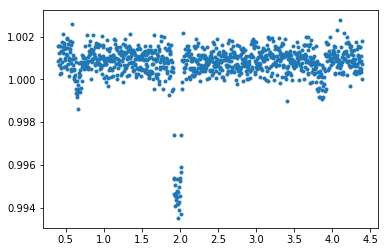

In [16]:
plt.plot(time, signal,'.')

In [ ]:
def get_likefunc(model, fixed):
    
    return

In [84]:
#Log likelihood function
def lnlike(p0, time, flux):
    # unpack p0
    t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, flux_err = p0
    # define model
    model = models_fit.phase_curve(time, per, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
    inv_sigma2 = 1.0/(flux_err**2)
    return -0.5*(np.sum((flux-model)**2*inv_sigma2) - len(flux)*np.log(inv_sigma2))

# Probability distribution to draw sample from
def lnprior(p0):
    t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, flux_err = p0
    if (1.5< t0 < 2.5 and 0 < rp < 1  and 0 < fp < 1 and 
        0 < q1 < 1 and 0 < q2 < 1):
        return 0.0 
    return -np.inf

# Total probability function
def lnprob(p0, time, flux):
    lp = lnprior(p0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p0, time, flux)

In [85]:
p0 = np.array([t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, sigmaf])

In [86]:
ndim, nwalkers, nstep = len(p0), 2*len(p0), 20 
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, signal))

In [87]:
pos, lnpro, state, = sampler.run_mcmc(pos, nstep)